In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
cd drive/My\ Drive/빅데이터/Bigdata_Python_MachineLearning/JEJU

신용카드 사용 내역 데이터(2019.01 ~ 2020.03)를 활용한 지역별, 업종별 월간 카드 사용 총액(2020.04) 예측

# 데이터셋 이해

REG_YYMM : 년월

CARD_SIDO_NM : 카드이용지역_시도 (가맹점 주소 기준)

CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)

STD_CLSS_NM : 업종명

HOM_SIDO_NM : 거주지역_시도, (고객 집주소 기준)

HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)

AGE : 연령대

SEX_CTGO_CD : 성별 (1: 남성, 2: 여성)

FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)

CSTMR_CNT : 이용고객수 (명)

AMT : 이용금액 (원)

CNT : 이용건수 (건)

# 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [2]:
data = pd.read_csv('201901-202003.csv')
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [3]:
# 날짜 처리
# REG_YYMM 컬럼은 8자리 숫자 형식으로 되어 있으므로 각각 연도와 월로 나눈다.

def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [4]:
data = data.fillna('')
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)

In [5]:
# 베이스라인
df = data.copy()

In [6]:
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM','HOM_CCG_NM','CARD_CCG_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [ ]:
# For문을 원하는 월 내의 지역, 업종으로 한정시킬 때 사용
# group_n = df[(df['year']==2020) & (df['month']==3)]
# group_n

In [7]:
group = df.groupby(['CARD_SIDO_NM','STD_CLSS_NM']).sum()
df1 = df.set_index(['CARD_SIDO_NM','STD_CLSS_NM'])

# EDA

- 대회 목표는 지역별 업종별 AMT 예측
- 업종별로 코로나-19의 영향력은 상이할 것

- 국내 코로나 첫 발병은 1월 20일
- 확진자 폭증의 원인인 신천지 31번째 환자 확진 2월 18일

In [8]:
# 연도, 월 별 '이용금액'과 '이용건수'
def month(a, b):
    data1 = df[df['year']==a]
    c = data1[data1['month']==b]
    d = c.groupby(['year','month','STD_CLSS_NM']).agg({'AMT':'sum','CNT':'sum'})
    e = d.reset_index()
    return e

# 전 월 대비 '이용금액'과 '이용건수'의 변동률
# AMT_dif, CNT_dif : 전 월 대비 변동률
def dif_month(x, y):
    def month(x, y):
        data1 = df[df['year']==x]
        c = data1[data1['month']==y]
        d = c.groupby(['year','month','STD_CLSS_NM']).agg({'AMT':'sum','CNT':'sum'})
        p = d.reset_index()
        return p
    i = y-1
    e = month(x, y)
    o = month(x, i)
    c = pd.DataFrame((e['AMT'] - o['AMT'])/o['AMT']*100)
    b = pd.DataFrame((e['CNT'] - o['CNT'])/o['CNT']*100)
    c = c.rename(columns={'AMT':'AMT_dif'})
    b = b.rename(columns={'CNT':'CNT_dif'})
    a = e.merge(c, left_index=True, right_index=True,  how='right')
    a = a.merge(b, left_index=True, right_index=True,  how='right')
    a = a[['year','month','STD_CLSS_NM','AMT','AMT_dif','CNT','CNT_dif']]
    return a.sort_values(ascending=False, by='AMT')

# 년도 별 '이용금액'과 '이용건수'의 변화량의 차이
# AMT_dif, CNT_dif : 전 년도 대비 변화량의 차이
def dif_year(x, y):
    x = x.drop(['AMT','CNT'], axis=1)
    z = y['AMT_dif'] - x['AMT_dif']
    f = y['CNT_dif'] - x['CNT_dif']
    c = pd.DataFrame(z)
    b = pd.DataFrame(f)
    x = x.rename(columns={'AMT_dif':'AMT'})
    x = x.rename(columns={'CNT_dif':'CNT'})
    a = x.merge(c, left_index=True, right_index=True,  how='right')
    a = a.merge(b, left_index=True, right_index=True,  how='right')
    a = a[['year','month','STD_CLSS_NM','AMT','AMT_dif','CNT','CNT_dif']]
    return a.sort_values(ascending=False, by='AMT') 

In [9]:
# 2019년 2월과 2020년 2월 비교
d_2019_02 = dif_month(2019, 2)
d_2020_02 = dif_month(2020, 2)
dif_year(d_2019_02, d_2020_02)

,year,month,STD_CLSS_NM,AMT,AMT_dif,CNT,CNT_dif
4,2019,2,그외 기타 분류안된 오락관련 서비스업,113.385749,-114.148147,129.629630,-131.144781
1,2019,2,골프장 운영업,35.125420,0.767820,16.554629,4.498072
28,2019,2,자동차 임대업,4.403611,-15.806800,-1.146550,-32.247541
12,2019,2,내항 여객 운송업,2.867066,-41.064141,0.895874,-33.055714
25,2019,2,육류 소매업,1.972364,-41.534066,-13.550413,-0.381226
29,2019,2,전시 및 행사 대행업,-3.954933,-59.909915,2.324616,-67.048787
16,2019,2,비알콜 음료점업,-5.544122,-10.503254,-7.520724,-5.478440
31,2019,2,중식 음식점업,-5.573510,-11.770870,-9.035609,-3.350056
21,2019,2,스포츠 및 레크레이션 용품 임대업,-5.669732,-19.752584,-2.915679,-22.323325
11,2019,2,기타음식료품위주종합소매업,-5.995830,-8.498936,-13.571053,11.462838


In [10]:
# 2019년 3월과 2020년 3월 비교
d_2019_03 = dif_month(2019, 3)
d_2020_03 = dif_month(2020, 3)
dif_year(d_2019_03, d_2020_03)

,year,month,STD_CLSS_NM,AMT,AMT_dif,CNT,CNT_dif
1,2019,3,골프장 운영업,160.368704,-44.233999,99.232131,-17.709965
12,2019,3,내항 여객 운송업,40.272511,-32.925653,30.454427,-7.670889
21,2019,3,스포츠 및 레크레이션 용품 임대업,31.878119,-16.254048,34.782299,-14.924485
13,2019,3,마사지업,23.842404,-50.843888,29.791460,-55.876197
3,2019,3,관광 민예품 및 선물용품 소매업,21.767837,-34.541310,25.969364,-47.078479
34,2019,3,체인화 편의점,21.100282,-17.085699,25.241929,-24.647951
9,2019,3,기타 외국식 음식점업,19.111344,-30.828903,22.189894,-32.253400
33,2019,3,차량용 주유소 운영업,18.826760,-18.817136,16.779664,-13.329309
37,2019,3,한식 음식점업,18.301432,-27.295419,21.605403,-28.697461
16,2019,3,비알콜 음료점업,17.946813,-20.499835,24.373476,-24.509281


## 월 단위 업종 별 AMT 변동률
- p : 2019년 시도별 AMT 변동률

In [11]:
df_p = df.groupby(['year','month','CARD_SIDO_NM']).agg({'AMT':'sum'})
df_p = df_p.loc[2019]
p = pd.DataFrame()
for month in range(2, 13):
    sample = (df_p.loc[month] - df_p.loc[month-1])/df_p.loc[month-1]*100
    sample['month'] = month
    p = pd.concat([p,sample],axis=0)
p

,AMT,month
CARD_SIDO_NM,,
강원,-12.137721,2
경기,-10.219891,2
경남,-10.076054,2
경북,-7.902388,2
광주,-10.050177,2
...,...,...
전남,2.104004,12
전북,2.733666,12
제주,3.536979,12


- q : 2019년 업종별 AMT 변동률

In [12]:
df_q = df.groupby(['year','month','STD_CLSS_NM']).agg({'AMT':'sum'})
df_q = df_q.loc[2019]
q = pd.DataFrame()
for month in range(2, 13):
    sample = (df_q.loc[month] - df_q.loc[month-1])/df_q.loc[month-1]*100
    sample['month'] = month
    q = pd.concat([q,sample],axis=0)
q

,AMT,month
STD_CLSS_NM,,
건강보조식품 소매업,-10.564641,2
골프장 운영업,35.125420,2
과실 및 채소 소매업,-7.279262,2
관광 민예품 및 선물용품 소매업,-12.522843,2
그외 기타 분류안된 오락관련 서비스업,113.385749,2
...,...,...
피자 햄버거 샌드위치 및 유사 음식점업,12.694894,12
한식 음식점업,12.209097,12
호텔업,59.556019,12


- i : 2020년 시도별 변동률

In [13]:
df_i = df.groupby(['year','month','CARD_SIDO_NM']).agg({'AMT':'sum'})
df_i = df_i.loc[2020]
i = pd.DataFrame()
for month in range(2, 4):
    sample = (df_i.loc[month] - df_i.loc[month-1])/df_i.loc[month-1]*100
    sample['month'] = month
    i = pd.concat([i,sample],axis=0)
i

,AMT,month
CARD_SIDO_NM,,
강원,-24.427437,2
경기,-16.771154,2
경남,-15.282468,2
경북,-18.277694,2
광주,-17.780600,2
대구,-19.878137,2
대전,-15.946421,2
부산,-19.785850,2
서울,-18.270424,2


-  r : 2020년 업종별 변동률

In [14]:
df_r = df.groupby(['year','month','STD_CLSS_NM']).agg({'AMT':'sum'})
df_r = df_r.loc[2020]
r = pd.DataFrame()
for month in range(2, 4):
    sample = (df_r.loc[month] - df_r.loc[month-1])/df_r.loc[month-1]*100
    sample['month']=month
    r = pd.concat([r,sample],axis=0)
r

,AMT,month
STD_CLSS_NM,,
건강보조식품 소매업,-48.559049,2
골프장 운영업,35.893240,2
과실 및 채소 소매업,-37.588942,2
관광 민예품 및 선물용품 소매업,-45.839865,2
그외 기타 분류안된 오락관련 서비스업,-0.762398,2
...,...,...
피자 햄버거 샌드위치 및 유사 음식점업,5.862381,3
한식 음식점업,-8.993987,3
호텔업,-53.947723,3


## 시각화

In [15]:
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

plt.rcParams['font.family'] = 'NanumGothic'

import matplotlib.font_manager as fm

path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()

plt.rc('font', family=font_name)

In [18]:
'''
f, axes = plt.subplots(9, 2, figsize=(20, 20))
i=0
j=0
for CLSS in q.index.unique():
    w = q.loc[CLSS]
    r_w = r.loc[CLSS]
    sns.lineplot(x=w.month,y=w.AMT, ax=axes[i, j]).set_title(CLSS)
    sns.lineplot(x=r.month, y= r.AMT, ax=axes[i,j]).set_title(CLSS)
    i+=1
    if i>=9:
        i=0
        j=1
plt.show()
'''

'\nf, axes = plt.subplots(9, 2, figsize=(20, 20))\ni=0\nj=0\nfor CLSS in q.index.unique():\n    w = q.loc[CLSS]\n    r_w = r.loc[CLSS]\n    sns.lineplot(x=w.month,y=w.AMT, ax=axes[i, j]).set_title(CLSS)\n    sns.lineplot(x=r.month, y= r.AMT, ax=axes[i,j]).set_title(CLSS)\n    i+=1\n    if i>=9:\n        i=0\n        j=1\nplt.show()\n'

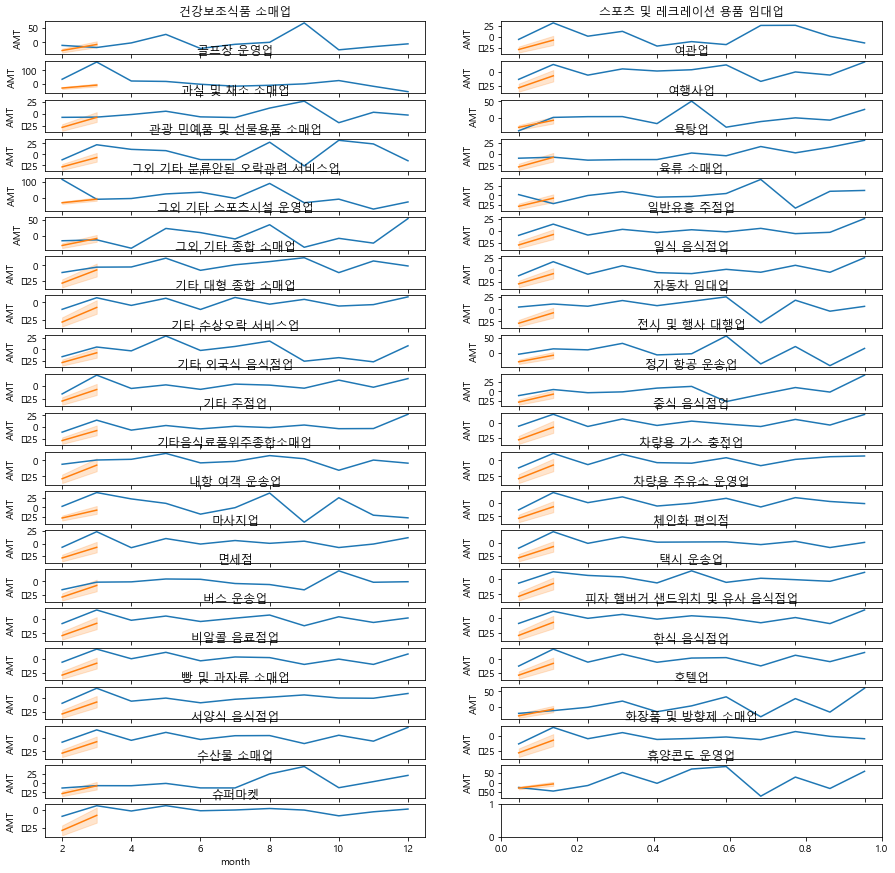

In [17]:
f, axes = plt.subplots(21, 2, figsize=(15, 15))
i=0
j=0
for CLSS in q.index.unique():
    w = q.loc[CLSS]
    r_w = r.loc[CLSS]
    sns.lineplot(x=w.month,y=w.AMT, ax=axes[i, j]).set_title(CLSS)
    sns.lineplot(x=r.month, y= r.AMT, ax=axes[i,j]).set_title(CLSS)
    i+=1
    if i>=21:
        i=0
        j=1
plt.show()

# 모델링

- 앞서 시행한 데이터 전처리와 EDA를 참고하여 for문을 통한 모델 구축

In [19]:
# 베이스라인
predict = pd.DataFrame()
# df = df.drop(['HOM_CCG_NM', 'CARD_CCG_NM'], axis=1)
for i,j in group.index:
    df = df1.loc[i,j] # 1번 강원-건강보조식품

    columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
    df = df.groupby(columns).sum().reset_index(drop=False) # 시군구 자동 드랍

    # 라벨 인코딩
    # 내가 간소화 함
    df_re = df.copy()
    columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM','AGE']
    for r in columns:
      encoder = LabelEncoder()
      encoded = encoder.fit(df[r])
      df_re[r] = encoded.transform(df[r])

  
    # 베이스라인
    # feature, target 설정
    train_num = df_re.sample(frac=1, random_state=0)
    x = train_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
    y = np.log1p(train_num['AMT'])

    try:
      k = int(len(x)*0.9)

      x_train = x[:k]
      y_train = y[:k]
      x_val = x[k:]
      y_val = y[k:]

      train_ds = lgb.Dataset(x_train, label=y_train)
      val_ds = lgb.Dataset(x_val, label=y_val)

      params = {'learning_rate' : 0.05,
                  'boosting_type': 'gbdt',
                  'objective': 'tweedie',
                  'tweedie_variance_power': 1.1,
                  'metric': 'rmse',
                  'sub_row' : 0.75,
                  'lambda_l2' : 0.1
                  }

      model = lgb.train(params,
                          train_ds,
                          1000,
                          val_ds,
                          verbose_eval = 100,
                          early_stopping_rounds = 100
                          )
    
      # 베이스라인
      # 예측 템플릿 만들기
      CARD_SIDO_NMs = df_re['CARD_SIDO_NM'].unique()
      STD_CLSS_NMs  = df_re['STD_CLSS_NM'].unique()
      HOM_SIDO_NMs  = df_re['HOM_SIDO_NM'].unique()
      AGEs          = df_re['AGE'].unique()
      SEX_CTGO_CDs  = df_re['SEX_CTGO_CD'].unique()
      FLCs          = df_re['FLC'].unique()
      years         = [2020]
      months        = [4]

      temp = []
      for CARD_SIDO_NM in CARD_SIDO_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
          for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
              for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                  for year in years:
                    for month in months:
                      temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])

      temp = np.array(temp)
      temp = pd.DataFrame(data=temp, columns=x.columns)

        
      pred = model.predict(temp)
      pred = np.expm1(pred)

      temp['AMT'] = np.round(pred, 0)

      temp['REG_YYMM'] = temp['year']*100 + temp['month']
      temp = temp[['REG_YYMM', 'AMT']]

      temp = temp.groupby('REG_YYMM').sum().reset_index(drop=False)

      temp['CARD_SIDO_NM'] = i
      temp['STD_CLSS_NM'] = j
      predict = predict.append(temp)
      print(i,j,"done")

    except:
      temp = pd.DataFrame()
      temp['REG_YYMM']=[202004]
      temp['CARD_SIDO_NM'] = i
      temp['STD_CLSS_NM'] = j
      temp['AMT']=0
      predict = predict.append(temp)
      print(i,j,"done")

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.899106
[200]	valid_0's rmse: 0.828418
[300]	valid_0's rmse: 0.812073
[400]	valid_0's rmse: 0.789942
[500]	valid_0's rmse: 0.778467
[600]	valid_0's rmse: 0.764394
[700]	valid_0's rmse: 0.754202
[800]	valid_0's rmse: 0.744724
[900]	valid_0's rmse: 0.745991
Early stopping, best iteration is:
[850]	valid_0's rmse: 0.743401
강원 건강보조식품 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.14771
[200]	valid_0's rmse: 1.0294
[300]	valid_0's rmse: 0.96718
[400]	valid_0's rmse: 0.933395
[500]	valid_0's rmse: 0.921166
[600]	valid_0's rmse: 0.917354
[700]	valid_0's rmse: 0.915093
[800]	valid_0's rmse: 0.911734
[900]	valid_0's rmse: 0.90968
[1000]	valid_0's rmse: 0.908437
Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 0.907405
강원 골프장 운영업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.00443
[200]	valid_0's rms

Early stopping, best iteration is:
[299]	valid_0's rmse: 0.528795
강원 일반유흥 주점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.856577
[200]	valid_0's rmse: 0.772554
[300]	valid_0's rmse: 0.724025
[400]	valid_0's rmse: 0.706446
[500]	valid_0's rmse: 0.698024
[600]	valid_0's rmse: 0.691299
[700]	valid_0's rmse: 0.683448
[800]	valid_0's rmse: 0.677064
[900]	valid_0's rmse: 0.674336
[1000]	valid_0's rmse: 0.672824
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.672778
강원 일식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.01609
Early stopping, best iteration is:
[82]	valid_0's rmse: 1.01506
강원 자동차 임대업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.25688
[200]	valid_0's rmse: 1.08771
[300]	valid_0's rmse: 1.02114
[400]	valid_0's rmse: 0.994816
[500]	valid_0's rmse: 0.969295
[600]	valid_0's rmse: 0.954342
[700]	valid_0's rmse: 0.949402
[

[594]	valid_0's rmse: 0.850424
경기 기타음식료품위주종합소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.990922
Early stopping, best iteration is:
[13]	valid_0's rmse: 0.844463
경기 내항 여객 운송업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.43939
[200]	valid_0's rmse: 1.33619
[300]	valid_0's rmse: 1.3531
Early stopping, best iteration is:
[224]	valid_0's rmse: 1.32505
경기 마사지업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.559653
[200]	valid_0's rmse: 0.43421
[300]	valid_0's rmse: 0.385218
[400]	valid_0's rmse: 0.362999
[500]	valid_0's rmse: 0.349959
[600]	valid_0's rmse: 0.339439
[700]	valid_0's rmse: 0.333561
[800]	valid_0's rmse: 0.329143
[900]	valid_0's rmse: 0.324663
[1000]	valid_0's rmse: 0.320916
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 0.320786
경기 버스 운송업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0'

[300]	valid_0's rmse: 0.950536
[400]	valid_0's rmse: 0.944171
[500]	valid_0's rmse: 0.936212
[600]	valid_0's rmse: 0.934818
[700]	valid_0's rmse: 0.933935
Early stopping, best iteration is:
[689]	valid_0's rmse: 0.932433
경기 택시 운송업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.831314
[200]	valid_0's rmse: 0.643202
[300]	valid_0's rmse: 0.574185
[400]	valid_0's rmse: 0.546787
[500]	valid_0's rmse: 0.533238
[600]	valid_0's rmse: 0.519176
[700]	valid_0's rmse: 0.513825
[800]	valid_0's rmse: 0.510846
[900]	valid_0's rmse: 0.508856
[1000]	valid_0's rmse: 0.505253
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.505253
경기 피자 햄버거 샌드위치 및 유사 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.918174
[200]	valid_0's rmse: 0.666322
[300]	valid_0's rmse: 0.619415
[400]	valid_0's rmse: 0.594356
[500]	valid_0's rmse: 0.579292
[600]	valid_0's rmse: 0.570908
[700]	valid_0's rmse: 0.56442
[80

[900]	valid_0's rmse: 0.69501
[1000]	valid_0's rmse: 0.690829
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 0.690641
경남 슈퍼마켓 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03679
[200]	valid_0's rmse: 0.972355
[300]	valid_0's rmse: 0.929882
[400]	valid_0's rmse: 0.906271
[500]	valid_0's rmse: 0.89424
[600]	valid_0's rmse: 0.884134
[700]	valid_0's rmse: 0.881625
[800]	valid_0's rmse: 0.878606
[900]	valid_0's rmse: 0.878535
[1000]	valid_0's rmse: 0.877946
Did not meet early stopping. Best iteration is:
[958]	valid_0's rmse: 0.877009
경남 스포츠 및 레크레이션 용품 임대업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12583
[200]	valid_0's rmse: 1.08846
[300]	valid_0's rmse: 1.07157
[400]	valid_0's rmse: 1.06091
[500]	valid_0's rmse: 1.05868
[600]	valid_0's rmse: 1.05686
[700]	valid_0's rmse: 1.06194
Early stopping, best iteration is:
[618]	valid_0's rmse: 1.05595
경남 여관업 done
Training until valid

경북 그외 기타 종합 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.777923
[200]	valid_0's rmse: 0.650422
[300]	valid_0's rmse: 0.609134
[400]	valid_0's rmse: 0.60323
[500]	valid_0's rmse: 0.598835
Early stopping, best iteration is:
[499]	valid_0's rmse: 0.598495
경북 기타 대형 종합 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.753059
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.741008
경북 기타 수상오락 서비스업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.986174
[200]	valid_0's rmse: 0.926957
[300]	valid_0's rmse: 0.913891
Early stopping, best iteration is:
[246]	valid_0's rmse: 0.907445
경북 기타 외국식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.06091
[200]	valid_0's rmse: 1.05444
Early stopping, best iteration is:
[142]	valid_0's rmse: 1.04381
경북 기타 주점업 done
Training until validation scores don't improve for 100 

경북 차량용 주유소 운영업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.928295
[200]	valid_0's rmse: 0.692825
[300]	valid_0's rmse: 0.637989
[400]	valid_0's rmse: 0.617288
[500]	valid_0's rmse: 0.601973
[600]	valid_0's rmse: 0.592361
[700]	valid_0's rmse: 0.582534
[800]	valid_0's rmse: 0.577282
[900]	valid_0's rmse: 0.574438
[1000]	valid_0's rmse: 0.571778
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 0.571607
경북 체인화 편의점 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.673515
Early stopping, best iteration is:
[38]	valid_0's rmse: 0.666725
경북 택시 운송업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.912705
[200]	valid_0's rmse: 0.799012
[300]	valid_0's rmse: 0.732841
[400]	valid_0's rmse: 0.695853
[500]	valid_0's rmse: 0.675175
[600]	valid_0's rmse: 0.660602
[700]	valid_0's rmse: 0.653491
[800]	valid_0's rmse: 0.647427
[900]	valid_0's rmse: 0.64490

[500]	valid_0's rmse: 0.833223
[600]	valid_0's rmse: 0.835487
Early stopping, best iteration is:
[513]	valid_0's rmse: 0.830738
광주 욕탕업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.687632
[200]	valid_0's rmse: 0.658062
[300]	valid_0's rmse: 0.662867
Early stopping, best iteration is:
[211]	valid_0's rmse: 0.657444
광주 육류 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.89065
[200]	valid_0's rmse: 0.774768
[300]	valid_0's rmse: 0.720112
[400]	valid_0's rmse: 0.709472
[500]	valid_0's rmse: 0.704402
[600]	valid_0's rmse: 0.703756
Early stopping, best iteration is:
[571]	valid_0's rmse: 0.70076
광주 일반유흥 주점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.57455
[200]	valid_0's rmse: 0.509968
[300]	valid_0's rmse: 0.507689
Early stopping, best iteration is:
[237]	valid_0's rmse: 0.503338
광주 일식 음식점업 done
Training until validation scores don't improve for 100 roun

[700]	valid_0's rmse: 0.815511
[800]	valid_0's rmse: 0.810406
Early stopping, best iteration is:
[795]	valid_0's rmse: 0.810101
대구 면세점 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.584662
[200]	valid_0's rmse: 0.583899
[300]	valid_0's rmse: 0.586929
Early stopping, best iteration is:
[214]	valid_0's rmse: 0.583809
대구 버스 운송업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.737837
[200]	valid_0's rmse: 0.643107
[300]	valid_0's rmse: 0.59828
[400]	valid_0's rmse: 0.579113
[500]	valid_0's rmse: 0.568501
[600]	valid_0's rmse: 0.562522
[700]	valid_0's rmse: 0.559591
Early stopping, best iteration is:
[696]	valid_0's rmse: 0.55933
대구 비알콜 음료점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.708441
[200]	valid_0's rmse: 0.599722
[300]	valid_0's rmse: 0.548535
[400]	valid_0's rmse: 0.533731
[500]	valid_0's rmse: 0.52843
[600]	valid_0's rmse: 0.525475
[700]	valid_0's r

[400]	valid_0's rmse: 1.23125
Early stopping, best iteration is:
[338]	valid_0's rmse: 1.22271
대구 호텔업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.909352
[200]	valid_0's rmse: 0.800867
[300]	valid_0's rmse: 0.755678
[400]	valid_0's rmse: 0.730433
[500]	valid_0's rmse: 0.717983
[600]	valid_0's rmse: 0.710692
[700]	valid_0's rmse: 0.709181
Early stopping, best iteration is:
[657]	valid_0's rmse: 0.708072
대구 화장품 및 방향제 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.55463
Early stopping, best iteration is:
[33]	valid_0's rmse: 1.48735
대전 건강보조식품 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0122
[200]	valid_0's rmse: 0.87284
[300]	valid_0's rmse: 0.839939
[400]	valid_0's rmse: 0.812232
[500]	valid_0's rmse: 0.804487
[600]	valid_0's rmse: 0.795306
[700]	valid_0's rmse: 0.792046
[800]	valid_0's rmse: 0.782349
[900]	valid_0's rmse: 0.780811
[1000]	valid_

[200]	valid_0's rmse: 0.656385
[300]	valid_0's rmse: 0.630318
[400]	valid_0's rmse: 0.620711
[500]	valid_0's rmse: 0.61506
[600]	valid_0's rmse: 0.608628
[700]	valid_0's rmse: 0.609835
Early stopping, best iteration is:
[638]	valid_0's rmse: 0.608
대전 중식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.65575
[200]	valid_0's rmse: 0.513165
[300]	valid_0's rmse: 0.471974
[400]	valid_0's rmse: 0.455201
[500]	valid_0's rmse: 0.444734
[600]	valid_0's rmse: 0.430517
[700]	valid_0's rmse: 0.424923
[800]	valid_0's rmse: 0.420769
[900]	valid_0's rmse: 0.42049
[1000]	valid_0's rmse: 0.424555
Did not meet early stopping. Best iteration is:
[904]	valid_0's rmse: 0.419969
대전 차량용 가스 충전업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.723904
[200]	valid_0's rmse: 0.616506
[300]	valid_0's rmse: 0.578247
[400]	valid_0's rmse: 0.559704
[500]	valid_0's rmse: 0.554691
[600]	valid_0's rmse: 0.551286
[700]	valid_0's rms

부산 비알콜 음료점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.826525
[200]	valid_0's rmse: 0.731372
[300]	valid_0's rmse: 0.673834
[400]	valid_0's rmse: 0.653213
[500]	valid_0's rmse: 0.625614
[600]	valid_0's rmse: 0.622852
[700]	valid_0's rmse: 0.615844
[800]	valid_0's rmse: 0.612957
[900]	valid_0's rmse: 0.612931
Early stopping, best iteration is:
[821]	valid_0's rmse: 0.612618
부산 빵 및 과자류 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.948295
[200]	valid_0's rmse: 0.810666
[300]	valid_0's rmse: 0.783002
[400]	valid_0's rmse: 0.77742
[500]	valid_0's rmse: 0.759124
[600]	valid_0's rmse: 0.75031
[700]	valid_0's rmse: 0.746171
[800]	valid_0's rmse: 0.745601
[900]	valid_0's rmse: 0.74342
[1000]	valid_0's rmse: 0.739471
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 0.739398
부산 서양식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.8142

[500]	valid_0's rmse: 0.572414
[600]	valid_0's rmse: 0.558516
[700]	valid_0's rmse: 0.55078
[800]	valid_0's rmse: 0.544601
[900]	valid_0's rmse: 0.540954
[1000]	valid_0's rmse: 0.539515
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 0.539354
부산 한식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04328
[200]	valid_0's rmse: 0.96108
[300]	valid_0's rmse: 0.924076
[400]	valid_0's rmse: 0.905691
[500]	valid_0's rmse: 0.899904
[600]	valid_0's rmse: 0.903771
Early stopping, best iteration is:
[534]	valid_0's rmse: 0.898183
부산 호텔업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.848752
[200]	valid_0's rmse: 0.771502
[300]	valid_0's rmse: 0.727326
[400]	valid_0's rmse: 0.711945
[500]	valid_0's rmse: 0.710053
[600]	valid_0's rmse: 0.706968
[700]	valid_0's rmse: 0.702147
[800]	valid_0's rmse: 0.697606
[900]	valid_0's rmse: 0.69861
Early stopping, best iteration is:
[808]	valid_0's rmse

[800]	valid_0's rmse: 0.556414
[900]	valid_0's rmse: 0.548966
[1000]	valid_0's rmse: 0.546714
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 0.546537
서울 서양식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04557
[200]	valid_0's rmse: 0.928578
[300]	valid_0's rmse: 0.887631
[400]	valid_0's rmse: 0.876978
[500]	valid_0's rmse: 0.87168
Early stopping, best iteration is:
[454]	valid_0's rmse: 0.869538
서울 수산물 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.755833
[200]	valid_0's rmse: 0.608042
[300]	valid_0's rmse: 0.55632
[400]	valid_0's rmse: 0.520849
[500]	valid_0's rmse: 0.502007
[600]	valid_0's rmse: 0.493184
[700]	valid_0's rmse: 0.483401
[800]	valid_0's rmse: 0.481183
[900]	valid_0's rmse: 0.480271
[1000]	valid_0's rmse: 0.479455
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 0.479292
서울 슈퍼마켓 done
Training until validation scores don't improve fo

[100]	valid_0's rmse: 0.706202
[200]	valid_0's rmse: 0.634481
[300]	valid_0's rmse: 0.622104
[400]	valid_0's rmse: 0.607943
[500]	valid_0's rmse: 0.608043
Early stopping, best iteration is:
[442]	valid_0's rmse: 0.605351
서울 화장품 및 방향제 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.722841
Early stopping, best iteration is:
[32]	valid_0's rmse: 0.707148
세종 건강보조식품 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.96498
[200]	valid_0's rmse: 0.89569
[300]	valid_0's rmse: 0.814887
[400]	valid_0's rmse: 0.724712
[500]	valid_0's rmse: 0.677304
[600]	valid_0's rmse: 0.647367
[700]	valid_0's rmse: 0.63325
[800]	valid_0's rmse: 0.626305
[900]	valid_0's rmse: 0.622731
[1000]	valid_0's rmse: 0.623391
Did not meet early stopping. Best iteration is:
[914]	valid_0's rmse: 0.622117
세종 골프장 운영업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.675513
[200]	valid_0's rmse: 

[100]	valid_0's rmse: 0.980048
[200]	valid_0's rmse: 0.84171
[300]	valid_0's rmse: 0.749602
[400]	valid_0's rmse: 0.700578
[500]	valid_0's rmse: 0.679974
[600]	valid_0's rmse: 0.66747
[700]	valid_0's rmse: 0.658981
[800]	valid_0's rmse: 0.657713
[900]	valid_0's rmse: 0.653527
[1000]	valid_0's rmse: 0.651709
Did not meet early stopping. Best iteration is:
[988]	valid_0's rmse: 0.65095
세종 한식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.887578
[200]	valid_0's rmse: 0.857713
[300]	valid_0's rmse: 0.854815
Early stopping, best iteration is:
[244]	valid_0's rmse: 0.850266
세종 화장품 및 방향제 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03571
[200]	valid_0's rmse: 0.858179
[300]	valid_0's rmse: 0.784099
[400]	valid_0's rmse: 0.739946
[500]	valid_0's rmse: 0.713773
[600]	valid_0's rmse: 0.700144
[700]	valid_0's rmse: 0.698492
[800]	valid_0's rmse: 0.691848
[900]	valid_0's rmse: 0.689238
[1000]	valid_0

[400]	valid_0's rmse: 0.760139
[500]	valid_0's rmse: 0.728118
[600]	valid_0's rmse: 0.710364
[700]	valid_0's rmse: 0.69284
[800]	valid_0's rmse: 0.676816
[900]	valid_0's rmse: 0.666317
[1000]	valid_0's rmse: 0.654276
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.654276
울산 일반유흥 주점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.703649
[200]	valid_0's rmse: 0.643012
[300]	valid_0's rmse: 0.624737
[400]	valid_0's rmse: 0.61996
[500]	valid_0's rmse: 0.6137
[600]	valid_0's rmse: 0.617201
Early stopping, best iteration is:
[540]	valid_0's rmse: 0.613202
울산 일식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.07348
Early stopping, best iteration is:
[15]	valid_0's rmse: 1.05794
울산 자동차 임대업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.21257
[200]	valid_0's rmse: 1.10259
[300]	valid_0's rmse: 1.02865
[400]	valid_0's rmse: 0.949597
[500

[500]	valid_0's rmse: 0.517559
[600]	valid_0's rmse: 0.512571
[700]	valid_0's rmse: 0.510902
[800]	valid_0's rmse: 0.50798
[900]	valid_0's rmse: 0.507767
[1000]	valid_0's rmse: 0.507312
Did not meet early stopping. Best iteration is:
[966]	valid_0's rmse: 0.506837
인천 면세점 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.692344
[200]	valid_0's rmse: 0.573903
[300]	valid_0's rmse: 0.54779
[400]	valid_0's rmse: 0.53867
[500]	valid_0's rmse: 0.536141
[600]	valid_0's rmse: 0.533677
[700]	valid_0's rmse: 0.531797
[800]	valid_0's rmse: 0.530255
Early stopping, best iteration is:
[799]	valid_0's rmse: 0.530188
인천 비알콜 음료점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.633024
[200]	valid_0's rmse: 0.561437
[300]	valid_0's rmse: 0.52198
[400]	valid_0's rmse: 0.50382
[500]	valid_0's rmse: 0.497285
[600]	valid_0's rmse: 0.49282
[700]	valid_0's rmse: 0.49099
[800]	valid_0's rmse: 0.490349
[900]	valid_0's rmse: 0.48

[355]	valid_0's rmse: 0.808555
인천 호텔업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0162
[200]	valid_0's rmse: 0.872401
Early stopping, best iteration is:
[188]	valid_0's rmse: 0.867966
인천 화장품 및 방향제 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02962
[200]	valid_0's rmse: 0.984405
[300]	valid_0's rmse: 0.96458
[400]	valid_0's rmse: 0.929697
[500]	valid_0's rmse: 0.912957
[600]	valid_0's rmse: 0.896161
[700]	valid_0's rmse: 0.889055
[800]	valid_0's rmse: 0.878109
[900]	valid_0's rmse: 0.86822
[1000]	valid_0's rmse: 0.866193
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.866193
전남 건강보조식품 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.07922
[200]	valid_0's rmse: 0.898569
[300]	valid_0's rmse: 0.809254
[400]	valid_0's rmse: 0.775602
[500]	valid_0's rmse: 0.76435
[600]	valid_0's rmse: 0.750468
[700]	valid_0's rmse: 0.747809
[

[200]	valid_0's rmse: 0.625527
[300]	valid_0's rmse: 0.588467
[400]	valid_0's rmse: 0.570904
[500]	valid_0's rmse: 0.561314
[600]	valid_0's rmse: 0.557319
[700]	valid_0's rmse: 0.55592
[800]	valid_0's rmse: 0.552203
[900]	valid_0's rmse: 0.549226
[1000]	valid_0's rmse: 0.549605
Did not meet early stopping. Best iteration is:
[911]	valid_0's rmse: 0.548855
전남 일식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.74651
Early stopping, best iteration is:
[52]	valid_0's rmse: 0.744622
전남 자동차 임대업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.918683
[200]	valid_0's rmse: 0.841113
[300]	valid_0's rmse: 0.822591
[400]	valid_0's rmse: 0.82178
[500]	valid_0's rmse: 0.819704
[600]	valid_0's rmse: 0.820549
Early stopping, best iteration is:
[562]	valid_0's rmse: 0.818243
전남 전시 및 행사 대행업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.919302
[200]	valid_0's rmse: 0.816

[690]	valid_0's rmse: 0.504983
전북 비알콜 음료점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.717685
[200]	valid_0's rmse: 0.625793
[300]	valid_0's rmse: 0.60788
[400]	valid_0's rmse: 0.591262
[500]	valid_0's rmse: 0.582958
[600]	valid_0's rmse: 0.576097
[700]	valid_0's rmse: 0.573629
[800]	valid_0's rmse: 0.574265
Early stopping, best iteration is:
[730]	valid_0's rmse: 0.572987
전북 빵 및 과자류 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.70283
[200]	valid_0's rmse: 0.634858
[300]	valid_0's rmse: 0.611762
[400]	valid_0's rmse: 0.607053
[500]	valid_0's rmse: 0.607042
Early stopping, best iteration is:
[450]	valid_0's rmse: 0.605188
전북 서양식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.691361
[200]	valid_0's rmse: 0.667512
[300]	valid_0's rmse: 0.666988
[400]	valid_0's rmse: 0.666899
Early stopping, best iteration is:
[375]	valid_0's rmse: 0.664569
전북 수산물

[200]	valid_0's rmse: 0.819947
[300]	valid_0's rmse: 0.822345
Early stopping, best iteration is:
[243]	valid_0's rmse: 0.814223
제주 골프장 운영업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.854546
[200]	valid_0's rmse: 0.823692
[300]	valid_0's rmse: 0.813881
[400]	valid_0's rmse: 0.802752
[500]	valid_0's rmse: 0.796536
[600]	valid_0's rmse: 0.792342
[700]	valid_0's rmse: 0.791411
[800]	valid_0's rmse: 0.792298
Early stopping, best iteration is:
[709]	valid_0's rmse: 0.791332
제주 과실 및 채소 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.718208
[200]	valid_0's rmse: 0.645719
[300]	valid_0's rmse: 0.624964
[400]	valid_0's rmse: 0.616895
[500]	valid_0's rmse: 0.612052
[600]	valid_0's rmse: 0.609278
[700]	valid_0's rmse: 0.605122
[800]	valid_0's rmse: 0.604143
Early stopping, best iteration is:
[790]	valid_0's rmse: 0.603629
제주 관광 민예품 및 선물용품 소매업 done
Training until validation scores don't improve for 100 rou

제주 자동차 임대업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.865109
[200]	valid_0's rmse: 0.753961
[300]	valid_0's rmse: 0.715372
[400]	valid_0's rmse: 0.696712
[500]	valid_0's rmse: 0.686307
[600]	valid_0's rmse: 0.680172
[700]	valid_0's rmse: 0.675484
[800]	valid_0's rmse: 0.671441
[900]	valid_0's rmse: 0.669482
[1000]	valid_0's rmse: 0.666473
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 0.666403
제주 전시 및 행사 대행업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.897821
[200]	valid_0's rmse: 0.797475
[300]	valid_0's rmse: 0.775307
[400]	valid_0's rmse: 0.756439
[500]	valid_0's rmse: 0.749814
[600]	valid_0's rmse: 0.741037
[700]	valid_0's rmse: 0.736282
[800]	valid_0's rmse: 0.735413
[900]	valid_0's rmse: 0.732232
Early stopping, best iteration is:
[883]	valid_0's rmse: 0.731725
제주 정기 항공 운송업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.6

[100]	valid_0's rmse: 0.702607
[200]	valid_0's rmse: 0.69493
[300]	valid_0's rmse: 0.690767
Early stopping, best iteration is:
[263]	valid_0's rmse: 0.688071
충남 버스 운송업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.872233
[200]	valid_0's rmse: 0.664666
[300]	valid_0's rmse: 0.578915
[400]	valid_0's rmse: 0.544186
[500]	valid_0's rmse: 0.523724
[600]	valid_0's rmse: 0.514439
[700]	valid_0's rmse: 0.50792
[800]	valid_0's rmse: 0.504663
[900]	valid_0's rmse: 0.503024
[1000]	valid_0's rmse: 0.501393
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.501341
충남 비알콜 음료점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.826807
[200]	valid_0's rmse: 0.689258
[300]	valid_0's rmse: 0.64558
[400]	valid_0's rmse: 0.621014
[500]	valid_0's rmse: 0.605292
[600]	valid_0's rmse: 0.597107
[700]	valid_0's rmse: 0.588591
[800]	valid_0's rmse: 0.588165
[900]	valid_0's rmse: 0.585277
[1000]	valid_0's rm

[400]	valid_0's rmse: 0.882777
[500]	valid_0's rmse: 0.876016
[600]	valid_0's rmse: 0.877661
Early stopping, best iteration is:
[513]	valid_0's rmse: 0.875443
충남 화장품 및 방향제 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17218
[200]	valid_0's rmse: 1.1322
[300]	valid_0's rmse: 1.11002
[400]	valid_0's rmse: 1.10326
[500]	valid_0's rmse: 1.09617
[600]	valid_0's rmse: 1.10049
Early stopping, best iteration is:
[510]	valid_0's rmse: 1.09571
충남 휴양콘도 운영업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1547
[200]	valid_0's rmse: 1.11951
Early stopping, best iteration is:
[196]	valid_0's rmse: 1.11876
충북 건강보조식품 소매업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.10493
[200]	valid_0's rmse: 0.982297
[300]	valid_0's rmse: 0.911855
[400]	valid_0's rmse: 0.856432
[500]	valid_0's rmse: 0.816504
[600]	valid_0's rmse: 0.789756
[700]	valid_0's rmse: 0.771913
[800]	valid_0

충북 자동차 임대업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.915261
[200]	valid_0's rmse: 0.902427
[300]	valid_0's rmse: 0.892497
[400]	valid_0's rmse: 0.884655
[500]	valid_0's rmse: 0.878665
[600]	valid_0's rmse: 0.874014
Early stopping, best iteration is:
[590]	valid_0's rmse: 0.873022
충북 전시 및 행사 대행업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.779537
[200]	valid_0's rmse: 0.681055
[300]	valid_0's rmse: 0.644456
[400]	valid_0's rmse: 0.631474
[500]	valid_0's rmse: 0.62416
[600]	valid_0's rmse: 0.621554
[700]	valid_0's rmse: 0.620073
[800]	valid_0's rmse: 0.617423
[900]	valid_0's rmse: 0.614745
[1000]	valid_0's rmse: 0.61431
Did not meet early stopping. Best iteration is:
[971]	valid_0's rmse: 0.614217
충북 중식 음식점업 done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.673979
[200]	valid_0's rmse: 0.576639
[300]	valid_0's rmse: 0.55609
[400]	valid_0's rmse: 0.543001

In [20]:
pd.options.display.float_format = '{:.1f}'.format
predict

,AMT,CARD_SIDO_NM,REG_YYMM,STD_CLSS_NM
0,648944525.0,강원,202004,건강보조식품 소매업
0,7231832130.0,강원,202004,골프장 운영업
0,1658780475.0,강원,202004,과실 및 채소 소매업
0,119170098.0,강원,202004,관광 민예품 및 선물용품 소매업
0,0.0,강원,202004,그외 기타 분류안된 오락관련 서비스업
...,...,...,...,...
0,1883766293.0,충북,202004,피자 햄버거 샌드위치 및 유사 음식점업
0,25947535389.0,충북,202004,한식 음식점업
0,137416177.0,충북,202004,호텔업
0,797091811.0,충북,202004,화장품 및 방향제 소매업


# 결과 해석 및 평가

- 4월 amt 가 들어간 데이터프레임 생성
- r2score(정확도)
- rmsle(오차율)


In [21]:
data4 = pd.read_csv('202004.csv')
true = data4.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum()['AMT']
true = true.reset_index()
true

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,88823988
1,202004,강원,골프장 운영업,4708346820
2,202004,강원,과실 및 채소 소매업,1121028924
3,202004,강원,관광 민예품 및 선물용품 소매업,14360780
4,202004,강원,그외 기타 스포츠시설 운영업,227200
...,...,...,...,...
605,202004,충북,피자 햄버거 샌드위치 및 유사 음식점업,1373635928
606,202004,충북,한식 음식점업,18911036160
607,202004,충북,호텔업,14121500
608,202004,충북,화장품 및 방향제 소매업,450507431


In [22]:
real = pd.merge(true, predict, how = 'left', on =['REG_YYMM', 'CARD_SIDO_NM','STD_CLSS_NM'] )
real = real.fillna(0)
real

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT_x,AMT_y
0,202004,강원,건강보조식품 소매업,88823988,648944525.0
1,202004,강원,골프장 운영업,4708346820,7231832130.0
2,202004,강원,과실 및 채소 소매업,1121028924,1658780475.0
3,202004,강원,관광 민예품 및 선물용품 소매업,14360780,119170098.0
4,202004,강원,그외 기타 스포츠시설 운영업,227200,29440774.0
...,...,...,...,...,...
605,202004,충북,피자 햄버거 샌드위치 및 유사 음식점업,1373635928,1883766293.0
606,202004,충북,한식 음식점업,18911036160,25947535389.0
607,202004,충북,호텔업,14121500,137416177.0
608,202004,충북,화장품 및 방향제 소매업,450507431,797091811.0


In [23]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(real.AMT_x, real.AMT_y))

1.7032949186193496